In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from keras.layers import Dense, Dropout
from keras.models import Sequential
from matplotlib import cm
from mpl_toolkits.mplot3d import *
from tensorflow import keras
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects, plot_model

Using TensorFlow backend.


In [2]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # mac

In [3]:
class PlotCurrentEstimate(tf.keras.callbacks.Callback):
    def __init__(self, x_valid, y_valid):
        """Keras Callback which plot current model estimate against reference target"""

        # convert numpy arrays into lists for plotting purposes
        self.x_valid = list(x_valid[:])
        self.y_valid = list(y_valid[:])
        self.iter = 0

    def on_epoch_end(self, epoch, logs={}):

        temp = self.model.predict(self.x_valid, batch_size=None, verbose=False, steps=None)
        self.y_curr = list(temp[:])  # convert numpy array into list

        self.iter += 1
        if self.iter % 10 == 0:
            clear_output(wait=True)
            self.eplot = plt.subplot(1, 1, 1)
            self.eplot.clear()
            self.eplot.scatter(
                self.x_valid, self.y_curr, color="blue", s=4, marker="o", label="estimate",
            )
            self.eplot.scatter(self.x_valid, self.y_valid, color="red", s=4, marker="x", label="valid")
            self.eplot.legend()

            plt.show()

In [4]:
def plot_network(model, history, row):

    ax[row, 0].plot(history.history["loss"], label="Train")
    ax[row, 0].plot(history.history["val_loss"], label="Test")
    ax[row, 0].title.set_text("Model loss")
    ax[row, 0].set_xlabel("Epoch")
    ax[row, 0].legend()
    ax[row, 0].grid(True)

    x_predicted = np.linspace(-1, 1, 100)
    y_predicted = model.predict(x_predicted)
    ax[row, 1].scatter(x_predicted, y_predicted, color="r", s=6, label="Prediction")
    ax[row, 1].scatter(x_valid, y_valid, s=2, label="Data")
    ax[row, 1].plot(x_valid, y_target, label="Theory")
    ax[row, 1].title.set_text("Prediction")
    ax[row, 1].legend()
    ax[row, 1].grid(True)
    ax[row, 1].set_xticklabels([])
    ax[row, 1].set_yticklabels([])

    lim = 1.25
    x_predicted = np.linspace(-lim, lim, 100)
    y_predicted = model.predict(x_predicted)
    x_extended = np.linspace(-lim, lim, 100)
    y_extended = polynomial(x_extended)
    ax[row, 2].scatter(x_predicted, y_predicted, color="r", label="Guess")
    ax[row, 2].plot(x_extended, y_extended, label="Theory")
    ax[row, 2].legend()
    ax[row, 2].title.set_text("Prediction on Extended Range")
    ax[row, 2].grid(True)
    #     ax[row, 2].set_xticklabels([])
    ax[row, 2].set_yticklabels([])

    return ax

# 11.1 Practice on Linear Regression

I trained a neural network (NN) on the labeled dataset $(x,y$ where $y_i = f(x_i) + \eta_i,$  $f(x) = mx + b$ and $\eta_i$ is a sample of normally distributed random noise.

In the end, we would like the NN to predict a $y_i$ given a $x_i$. This prediction will be subject to error due to the random noise, but the NN will attempt to find the parameters that allow it to predict the entire training dataset. 


The assignment notebook uses the following parameters:
- 1 neuron
- batch size of 32
- 50 epochs
- 500/50 training and validation

To test these parameters, I chose to challenge the NN with $\sigma = 2.0$.

Results:

![](figs/original_loss.png)

![](figs/original_fit.png)

**Figure: Linear regression by simple neural network.** The plateau in the loss/cost curve suggests that improving the model would require more than simply increasing the number of epochs. I'll try increasing the number of training points.

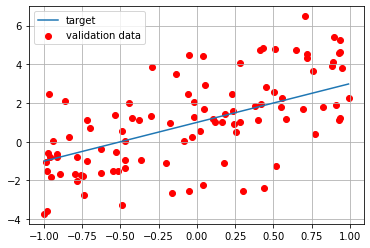

In [5]:
# target parameters of f(x) = m*x + b
m = 2  # slope
b = 1  # intersect

# noise on data
sigma = 2.0

N_train = 1000
# N_valid = N_train / 10

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, int(N_train / 10))
x_valid.sort()

y_target = m * x_valid + b  # ideal (target) linear function (noise = 0)

y_train = np.random.normal(m * x_train + b, sigma)

# actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

# plot validation and target dataset
plt.plot(x_valid, y_target, label="target")
plt.scatter(x_valid, y_valid, color="r", label="validation data")
plt.legend()
plt.grid(True)
plt.show()

**Figure: Noisy linear data.**

In [6]:
model = Sequential()
model._name = "SeqModel"
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer="sgd", loss="mse", metrics=["mse"])

# get a summary of our composed model
model.summary()

Model: "SeqModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, mode="auto", verbose=1),
    PlotCurrentEstimate(x_valid, y_valid),
]

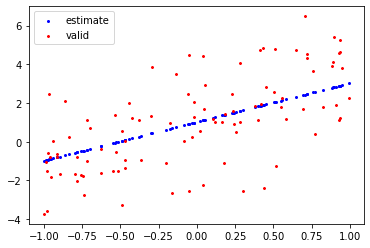

1000/1000 [==============================] - 0s 370us/sample - loss: 3.7943 - mse: 3.7943 - val_loss: 3.2885 - val_mse: 3.2885


In [8]:
N_epochs = 50
batch_size = 32

# Training
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea is to shuffle input before at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

In [65]:
# Check weights
print("Original m and b:")
print(m, b)
print("Get m and b: ")
model.get_weights()

Original m and b:
2 1
Get m and b: 


[array([[2.022429]], dtype=float32), array([1.0080923], dtype=float32)]

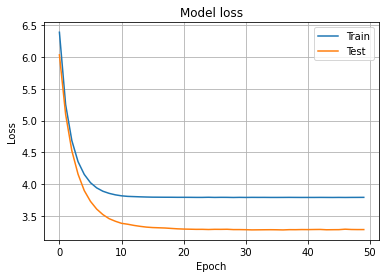

In [9]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.grid(True)
# plt.savefig('figs/original_loss.png')
plt.show()

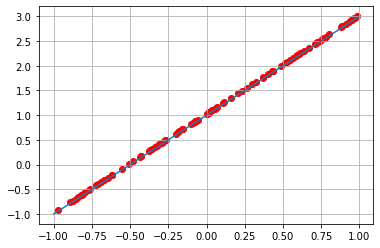

In [10]:
# Use the model to make a prediction
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted, color="r")
plt.plot(x_valid, y_target)
plt.grid(True)
# plt.savefig('figs/original_fit.png')
plt.show()

# 11.2 Noisy Polynomial

$f(x)=4-3x-2x^2+3x^3 $ for $x \in [-1,1]$.

Try exploring:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function

I'd like to find the simplest network that can solve this problem.

In [11]:
def polynomial(x):
    p = [3, -2, -3, 4]
    return p[0] * x ** 3 + p[1] * x ** 2 + p[2] * x + p[3]

In [12]:
# noise
sigma = 1.0

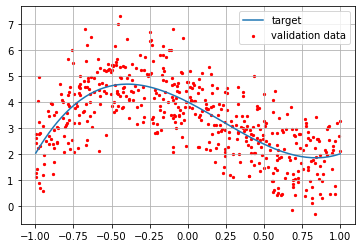

In [16]:
N_train = 5000
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, int(N_train / 10))
x_valid.sort()

y_target = polynomial(x_valid)  # ideal (target) linear function
y_train = np.random.normal(polynomial(x_train), sigma)  # training data
y_valid = np.random.normal(polynomial(x_valid), sigma)  # validation data

# plot validation and target dataset
plt.plot(x_valid, y_target, label="target")
plt.scatter(x_valid, y_valid, s=5, color="r", label="validation data")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
N_epochs = 50
batch_size = 32

In [22]:
# Callbacks
callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, mode="auto", verbose=1),
    PlotCurrentEstimate(x_valid, y_valid),
]

## Exploration of number of layers and neurons

### Model A
Model A is the neural network used in the previous example. It does a poor job and is only capable of fitting a line to the data.

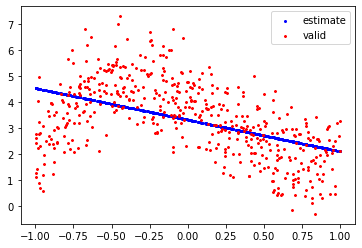

5000/5000 [==============================] - 1s 118us/sample - loss: 1.5794 - mse: 1.5794 - val_loss: 1.5940 - val_mse: 1.5940


In [23]:
model_a = Sequential()
model_a._name = "model_a"
model_a.add(Dense(units=1, input_dim=1, activation="relu"))
model_a.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_a.summary()

history_model_a = model_a.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model B

Model B has a 1-5-1 structure equaling 16 parameters. 

$(5 + 5) + (5 + 1) = 16$

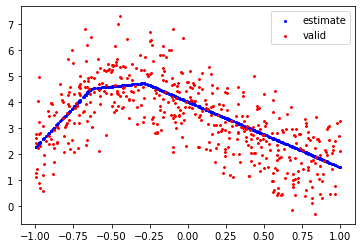

5000/5000 [==============================] - 1s 170us/sample - loss: 1.0101 - mse: 1.0101 - val_loss: 1.0048 - val_mse: 1.0048


In [24]:
# Neural Network B
model_b = Sequential()
model_b._name = "model_b"
model_b.add(Dense(units=5, input_dim=1, activation="relu"))
model_b.add(Dense(units=1, activation="relu"))
model_b.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_b.summary()

history_model_b = model_b.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model C

Will more neurons equal better results? Model C has a 1-5-10-1 structure equaling 81 parameters.

$(5 + 5) + (5*10 + 10) + (10 + 1) = 81 $

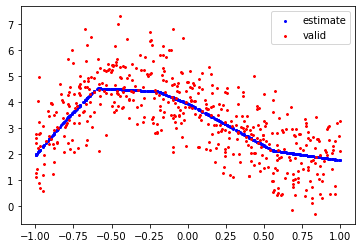

5000/5000 [==============================] - 1s 191us/sample - loss: 0.9936 - mse: 0.9936 - val_loss: 0.9747 - val_mse: 0.9747


In [25]:
# Neural Network C
model_c = Sequential()
model_c._name = "model_c"
model_c.add(Dense(units=5, input_dim=1, activation="relu"))
model_c.add(Dense(units=10, input_dim=1, activation="relu"))
model_c.add(Dense(units=1, activation="relu"))
model_c.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_c.summary()

history_model_c = model_c.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model D

Does the order of the layers matter? Model D has a 1-10-5-1 structure.

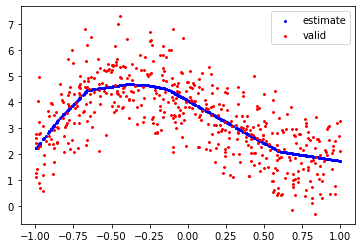

5000/5000 [==============================] - 1s 149us/sample - loss: 0.9910 - mse: 0.9910 - val_loss: 0.9599 - val_mse: 0.9599


In [26]:
# Neural Network D
model_d = Sequential()
model_d._name = "model_d"
model_d.add(Dense(units=10, input_dim=1, activation="relu"))
model_d.add(Dense(units=5, activation="relu"))
model_d.add(Dense(units=1, activation="relu"))
model_d.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_d.summary()

history_model_d = model_d.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model E

Adding a fairly extreme number of neurons: 1-100-10-5-1. (1,271 parameters)

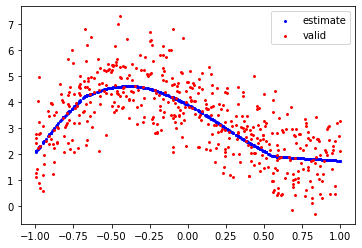

5000/5000 [==============================] - 1s 164us/sample - loss: 0.9894 - mse: 0.9894 - val_loss: 0.9677 - val_mse: 0.9677
Epoch 49/50
5000/5000 [==============================] - 1s 105us/sample - loss: 0.9919 - mse: 0.9919 - val_loss: 1.0022 - val_mse: 1.0022
Epoch 50/50
5000/5000 [==============================] - 1s 107us/sample - loss: 0.9957 - mse: 0.9957 - val_loss: 0.9601 - val_mse: 0.9601


In [30]:
# Neural Network E
model_e = Sequential()
model_e._name = "model_e"
model_e.add(Dense(units=100, input_dim=1, activation="relu"))
model_e.add(Dense(units=10, activation="relu"))
model_e.add(Dense(units=5, activation="relu"))
model_e.add(Dense(units=1, activation="relu"))
model_e.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_e.summary()

history_model_e = model_e.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

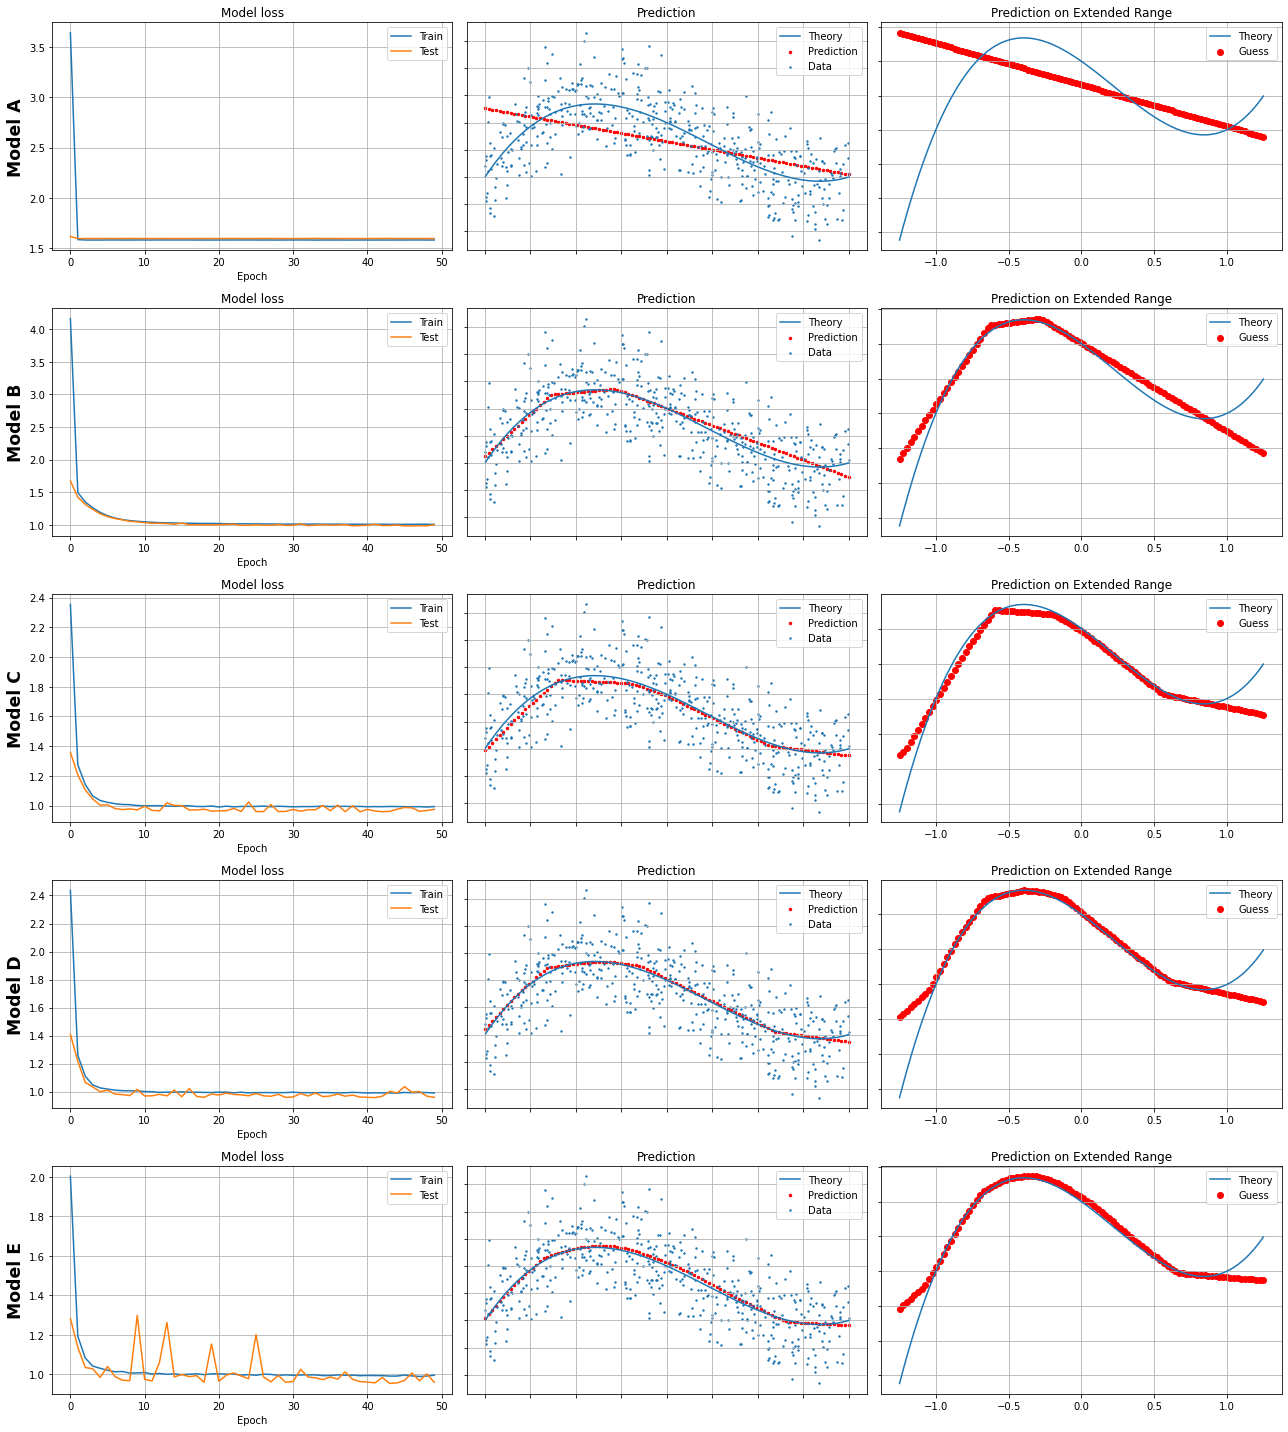

In [31]:
# Compare the  networks
fig, ax = plt.subplots(5, 3, figsize=(18, 20))
# fig.suptitle("Models A, B, C, D, E")

ax = plot_network(model_a, history_model_a, 0)
ax[0, 0].set_ylabel("Model A", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_b, history_model_b, 1)
ax[1, 0].set_ylabel("Model B", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_c, history_model_c, 2)
ax[2, 0].set_ylabel("Model C", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_d, history_model_d, 3)
ax[3, 0].set_ylabel("Model D", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_e, history_model_e, 4)
ax[4, 0].set_ylabel("Model E", fontsize="xx-large", fontweight="semibold")
plt.tight_layout()

- A: 1 neuron
- B: 1-5-1
- C: 1-5-10-1
- D: 1-10-5-1
- E: 1-100-10-5-1

**Comment.** As expected, Model E (the most complex network) was best suited to the task of identifying the underlying feature. However, none of the networks so far excelled at predicting data out of range. It seems to me that the number of neurons in the network roughly corrisponds with the number of line segments the network is capable of using in order to detect the feature.

## Exploring Built-In Activation functions

**relu**, sigmoid, softmax, **softplus**, softsign, tanh, **selu**, **elu**, exponential

**Sigmoid yielded the vanishing gradient problem!**

### Model X

Model X is model E with softplus activation. 

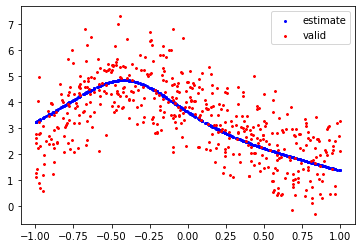

5000/5000 [==============================] - 1s 165us/sample - loss: 1.0635 - mse: 1.0635 - val_loss: 1.0686 - val_mse: 1.0686
Epoch 49/50
5000/5000 [==============================] - 1s 204us/sample - loss: 1.0581 - mse: 1.0581 - val_loss: 1.3763 - val_mse: 1.3763
Epoch 50/50
5000/5000 [==============================] - 1s 159us/sample - loss: 1.0557 - mse: 1.0557 - val_loss: 1.0905 - val_mse: 1.0905


In [36]:
# Neural Network X
activation = activations.softplus
model_x = Sequential()
model_x._name = "model_x"
model_x.add(Dense(units=100, input_dim=1, activation=activation))
model_x.add(Dense(units=10, activation=activation))
model_x.add(Dense(units=5, activation=activation))
model_x.add(Dense(units=1, activation=activation))
model_x.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_x.summary()

history_model_x = model_x.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model Y

Model Y is model E with selu activation. 

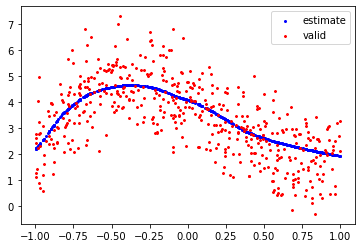

5000/5000 [==============================] - 1s 294us/sample - loss: 1.0045 - mse: 1.0045 - val_loss: 0.9940 - val_mse: 0.9940
Epoch 49/50
5000/5000 [==============================] - 1s 233us/sample - loss: 1.0033 - mse: 1.0033 - val_loss: 0.9629 - val_mse: 0.9629
Epoch 50/50
5000/5000 [==============================] - 1s 229us/sample - loss: 1.0026 - mse: 1.0026 - val_loss: 0.9752 - val_mse: 0.9752


In [33]:
# Neural Network Y
activation = activations.selu
model_y = Sequential()
model_y._name = "model_y"
model_y.add(Dense(units=100, input_dim=1, activation=activation))
model_y.add(Dense(units=10, activation=activation))
model_y.add(Dense(units=5, activation=activation))
model_y.add(Dense(units=1, activation=activation))
model_y.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_y.summary()

history_model_y = model_y.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model Z

Model Z is model E with elu activation

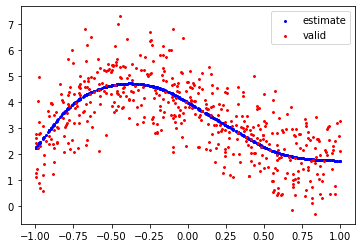

5000/5000 [==============================] - 1s 230us/sample - loss: 0.9944 - mse: 0.9944 - val_loss: 0.9565 - val_mse: 0.9565
Epoch 49/50
5000/5000 [==============================] - 1s 234us/sample - loss: 0.9930 - mse: 0.9930 - val_loss: 0.9625 - val_mse: 0.9625
Epoch 50/50
5000/5000 [==============================] - 1s 202us/sample - loss: 0.9923 - mse: 0.9923 - val_loss: 0.9697 - val_mse: 0.9697


In [34]:
# Neural Network Z
activation = activations.elu
model_z = Sequential()
model_z._name = "model_z"
model_z.add(Dense(units=100, input_dim=1, activation=activation))
model_z.add(Dense(units=10, activation=activation))
model_z.add(Dense(units=5, activation=activation))
model_z.add(Dense(units=1, activation=activation))
model_z.compile(optimizer="sgd", loss="mse", metrics=["mse"])
model_z.summary()

history_model_z = model_z.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Plot

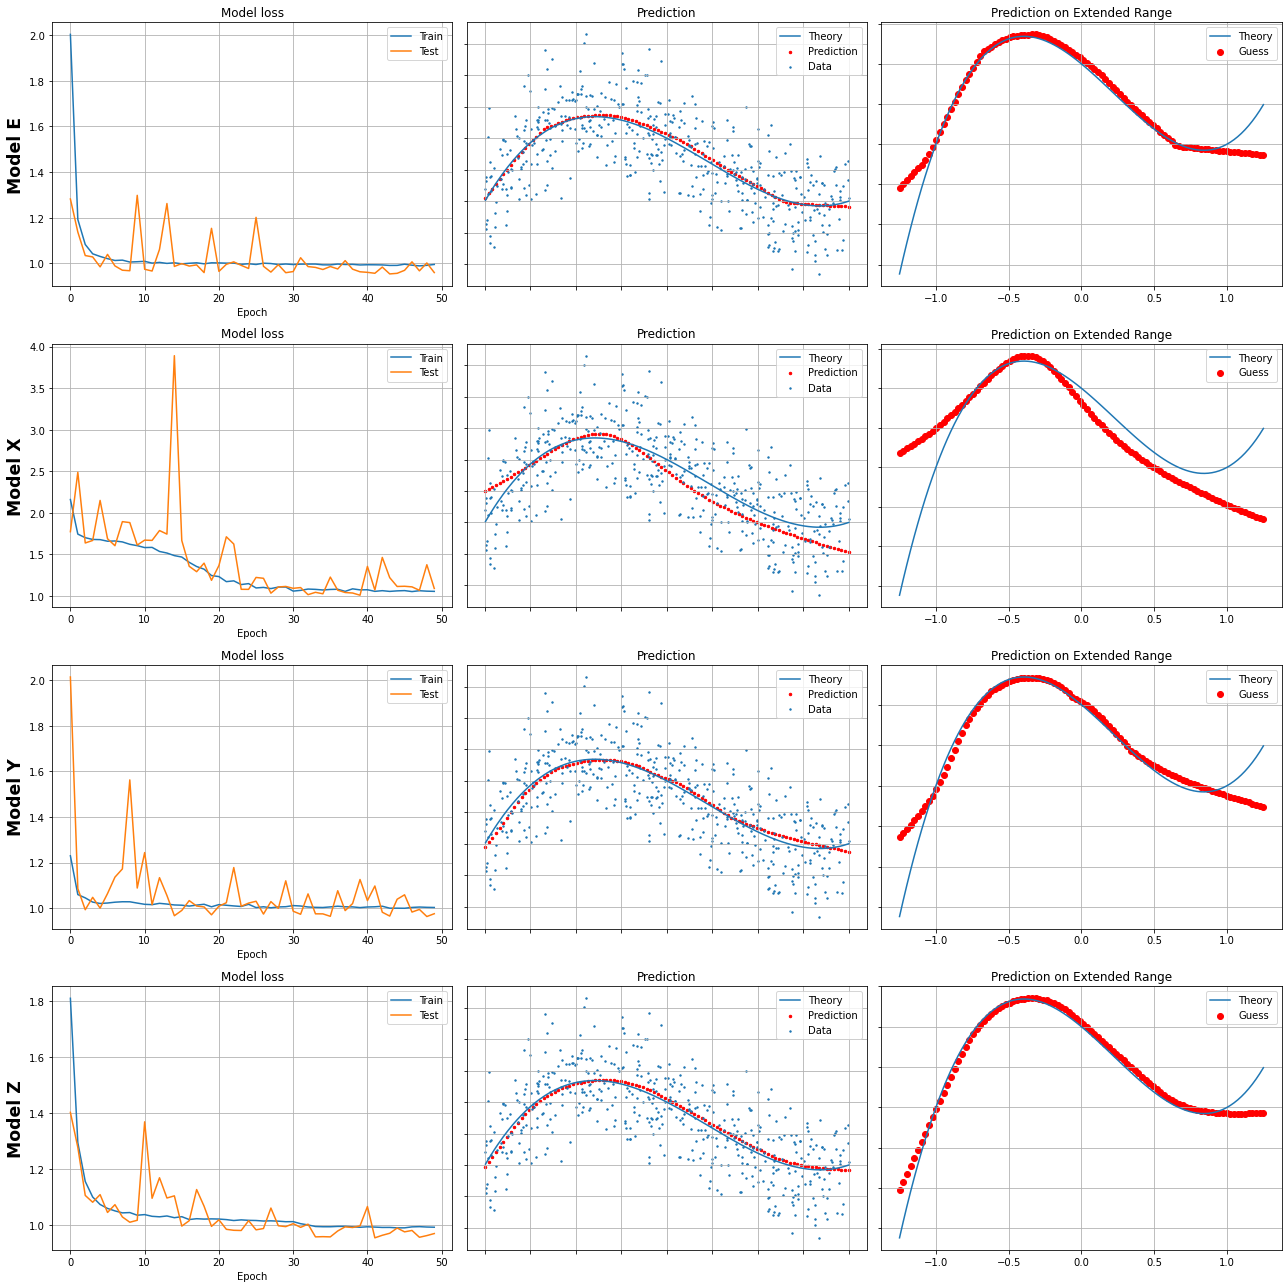

In [37]:
# Compare the  networks
fig, ax = plt.subplots(4, 3, figsize=(18, 18))

ax = plot_network(model_e, history_model_e, 0)
ax[0, 0].set_ylabel("Model E", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_x, history_model_x, 1)
ax[1, 0].set_ylabel("Model X", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_y, history_model_y, 2)
ax[2, 0].set_ylabel("Model Y", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_z, history_model_z, 3)
ax[3, 0].set_ylabel("Model Z", fontsize="xx-large", fontweight="semibold")

plt.tight_layout()

- E: 1-100-10-5-1, relu
- X: 1-100-10-5-1, softplus
- Y: 1-100-10-5-1, selu
- Z: 1-100-10-5-1, elu

**Comment.** Model E (ReLU) and model Z (ELU) seem to be the best for this configuration.

## Exploring Optimizers

**SGD**, **RMSprop**, **Adam**, Adadelta, Adagrad, **Adamax**, **Nadam**, Ftrl

(The names in bold are optimizers that proved functional.)

In [38]:
N_epochs = 50
batch_size = 32


### Model U

Model U is model E with RMSprop optimization.



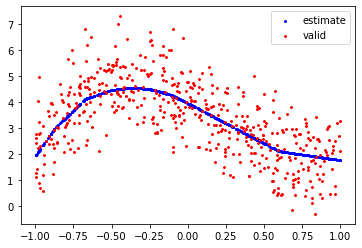

5000/5000 [==============================] - 1s 170us/sample - loss: 0.9968 - mse: 0.9968 - val_loss: 0.9722 - val_mse: 0.9722
Epoch 49/50
5000/5000 [==============================] - 1s 125us/sample - loss: 0.9941 - mse: 0.9941 - val_loss: 0.9635 - val_mse: 0.9635
Epoch 50/50
5000/5000 [==============================] - 1s 124us/sample - loss: 0.9959 - mse: 0.9959 - val_loss: 0.9678 - val_mse: 0.9678


In [39]:
# Neural Network X
activation = activations.relu
optimizer = optimizers.RMSprop()
model_u = Sequential()
model_u._name = "model_u"
model_u.add(Dense(units=100, input_dim=1, activation=activation))
model_u.add(Dense(units=10, activation=activation))
model_u.add(Dense(units=5, activation=activation))
model_u.add(Dense(units=1, activation=activation))
model_u.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
model_u.summary()

history_model_u = model_u.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model V

Model E with Adaptive Momentum

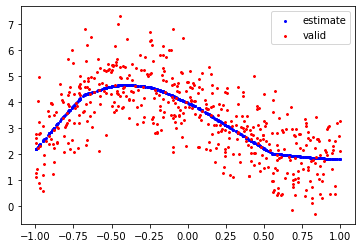

5000/5000 [==============================] - 1s 166us/sample - loss: 0.9933 - mse: 0.9933 - val_loss: 0.9546 - val_mse: 0.9546
Epoch 49/50
5000/5000 [==============================] - 1s 138us/sample - loss: 0.9973 - mse: 0.9973 - val_loss: 0.9648 - val_mse: 0.9648
Epoch 50/50
5000/5000 [==============================] - 1s 130us/sample - loss: 0.9965 - mse: 0.9965 - val_loss: 0.9770 - val_mse: 0.9770


In [40]:
# Neural Network V
activation = activations.relu
optimizer = optimizers.RMSprop()
model_v = Sequential()
model_v._name = "model_v"
model_v.add(Dense(units=100, input_dim=1, activation=activation))
model_v.add(Dense(units=10, activation=activation))
model_v.add(Dense(units=5, activation=activation))
model_v.add(Dense(units=1, activation=activation))
model_v.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
model_v.summary()

history_model_v = model_v.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Model W

Model E with Nadam.

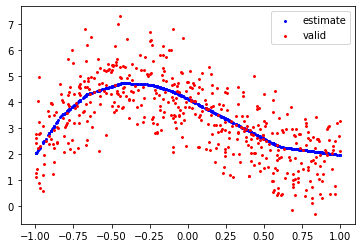

5000/5000 [==============================] - 1s 236us/sample - loss: 0.9889 - mse: 0.9889 - val_loss: 0.9840 - val_mse: 0.9840
Epoch 49/50
5000/5000 [==============================] - 1s 186us/sample - loss: 0.9917 - mse: 0.9917 - val_loss: 0.9613 - val_mse: 0.9613
Epoch 50/50
5000/5000 [==============================] - 1s 166us/sample - loss: 0.9932 - mse: 0.9932 - val_loss: 0.9595 - val_mse: 0.9595


In [41]:
# Neural Network V
activation = activations.relu
optimizer = optimizers.Nadam()
model_w = Sequential()
model_w._name = "model_w"
model_w.add(Dense(units=100, input_dim=1, activation=activation))
model_w.add(Dense(units=10, activation=activation))
model_w.add(Dense(units=5, activation=activation))
model_w.add(Dense(units=1, activation=activation))
model_w.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
model_w.summary()

history_model_w = model_w.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,  # a good idea : shuffle input at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

### Plot

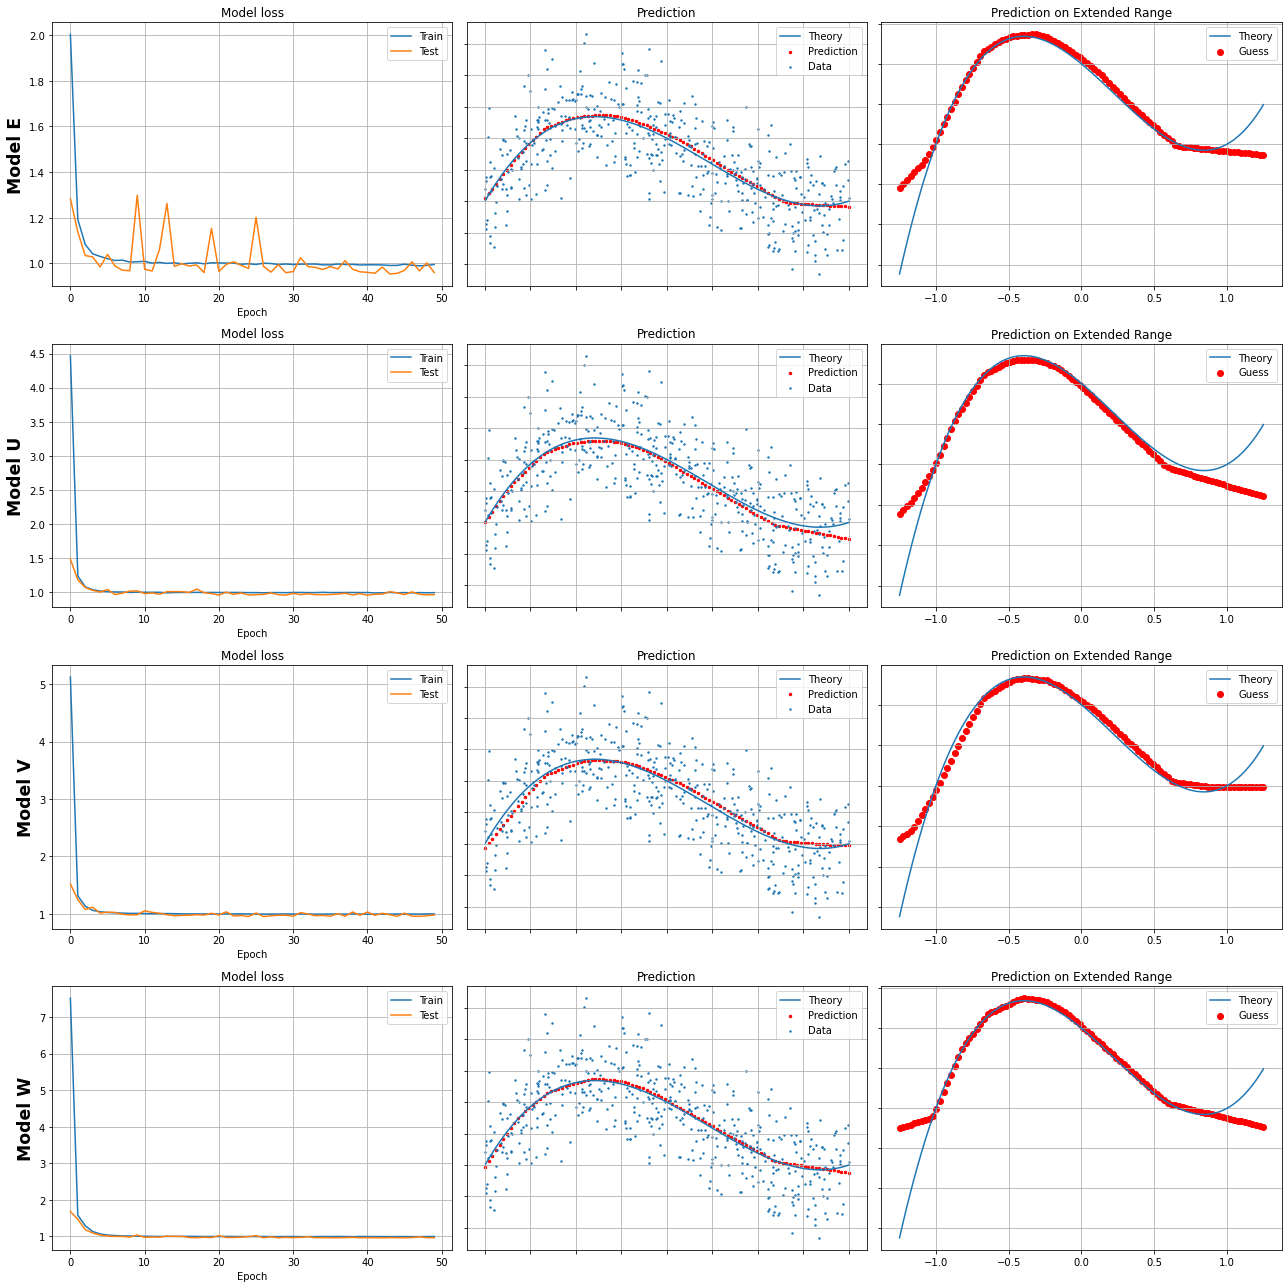

In [42]:
# Compare the  networks
fig, ax = plt.subplots(4, 3, figsize=(18, 18))

ax = plot_network(model_e, history_model_e, 0)
ax[0, 0].set_ylabel("Model E", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_u, history_model_u, 1)
ax[1, 0].set_ylabel("Model U", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_v, history_model_v, 2)
ax[2, 0].set_ylabel("Model V", fontsize="xx-large", fontweight="semibold")
ax = plot_network(model_w, history_model_w, 3)
ax[3, 0].set_ylabel("Model W", fontsize="xx-large", fontweight="semibold")

plt.tight_layout()

- Model E: SGD
- Model U: RMSprop
- Model V: Adam
- Model W: Nadam

**Comment.** The final models are all fairly accurate. But the model losses are evidence of the flaw of vanilla stochastic gradient descent: oscillation around the local minimum. However, all other models don't seem to be doing an excellent job. Perhaps they could be improved by changing some of the optimizer parameters.

RMSprop, Adam, and Nadam all use momentum to allow the model to quickly "settle" into the local minimum. 

# 11.3 Simple trigonometric 2D function.

In [43]:
def periodic(x, y):
    return np.sin(x ** 2 + y ** 2)

In [44]:
# noise
sigma = 1.0

## Data

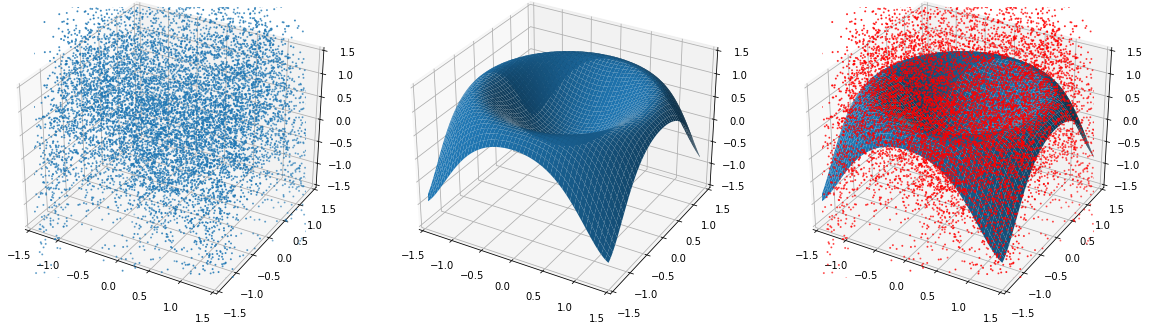

In [45]:
N_train = 10000

# Generate random points (x,y)
x_train = np.random.uniform(-3 / 2, 3 / 2, (N_train, 2))
x_valid = np.random.uniform(-3 / 2, 3 / 2, (int(N_train / 10), 2))

y_target = periodic(x_valid[:, 0], x_valid[:, 1])  # theory
y_train = np.random.normal(periodic(x_train[:, 0], x_train[:, 1]), sigma)  # training data
y_valid = np.random.normal(periodic(x_valid[:, 0], x_valid[:, 1]), sigma)  # validation data

fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax = fig.gca(projection="3d")  # to work in 3d
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, s=1)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.dist = 8

ax = fig.add_subplot(1, 3, 2, projection="3d")
x_surf = np.arange(-3 / 2, 3 / 2, 0.01)
y_surf = np.arange(-3 / 2, 3 / 2, 0.01)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
z_surf = periodic(x_surf, y_surf)
ax.plot_surface(x_surf, y_surf, z_surf)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.dist = 8

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, s=1, color="r")
x_surf = np.arange(-3 / 2, 3 / 2, 0.01)
y_surf = np.arange(-3 / 2, 3 / 2, 0.01)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
z_surf = periodic(x_surf, y_surf)
ax.plot_surface(x_surf, y_surf, z_surf)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.dist = 8

plt.show()

## Build and Train

In [53]:
# Neural Network

activation = activations.relu
optimizer = optimizers.Adam()
model = Sequential(name="Regresion")
model.add(Dense(units=100, input_shape=(2,), activation=activation))
model.add(Dense(units=16, activation=activation))
model.add(Dense(units=100, activation=activation))
model.add(Dense(units=16, activation=activation))
model.add(Dense(units=8, activation=activation))
model.add(Dense(units=1))  # output layer

model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])

model.summary()

Model: "Regresion"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_62 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_63 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_64 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 9         
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_______________________________________________________

In [54]:
class PlotCurrentEstimate3D(tf.keras.callbacks.Callback):
    def __init__(self, x_valid, y_valid):
        """Keras Callback which plot current model estimate against reference target"""

        self.x_valid = x_valid
        self.y_valid = y_valid
        self.iter = 0

    def on_epoch_end(self, epoch, logs={}):

        self.y_curr = self.model.predict(self.x_valid)

        self.iter += 1
        if self.iter % 10 == 0:  # every 10 epochs
            clear_output(wait=True)
            self.eplot = plt.subplot(1, 1, 1, projection="3d")
            self.eplot.clear()
            self.eplot.scatter(
                self.x_valid[:, 0], self.x_valid[:, 1], self.y_curr, color="blue", s=4, marker="o", label="estimate",
            )
            self.eplot.scatter(
                self.x_valid[:, 0], self.x_valid[:, 1], self.y_valid, color="red", s=4, marker="x", label="valid",
            )
            self.eplot.legend()

            plt.show()

In [55]:
# Callbacks
callbacks = [PlotCurrentEstimate3D(x_valid, y_valid)]

In [56]:
N_epochs = 50
batch_size = 32

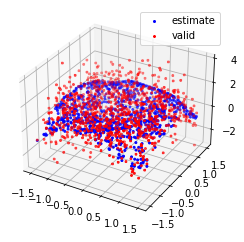

10000/10000 [==============================] - 2s 215us/sample - loss: 1.0200 - mse: 1.0200 - val_loss: 0.9829 - val_mse: 0.9829


In [57]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=N_epochs,
    shuffle=True,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks,
)

## Results

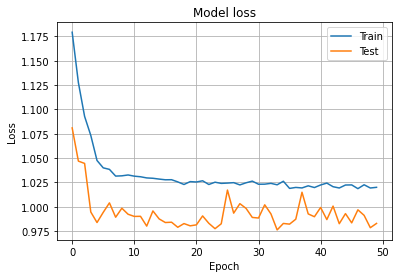

In [58]:
# Plot training & validation loss values
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

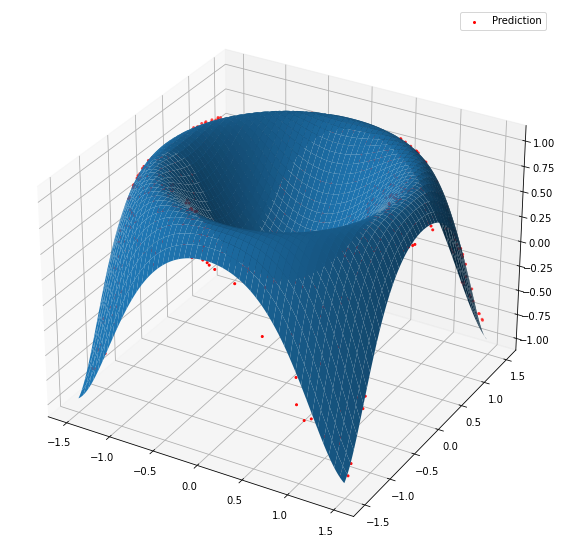

In [59]:
fig = plt.figure(figsize=(24, 10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

x_predicted = np.random.uniform(-3 / 2, 3 / 2, (int(N_train / 10), 2))
y_predicted = model.predict(x_predicted)
ax.scatter(
    x_predicted[:, 0], x_predicted[:, 1], y_predicted, s=4, color="r", label="Prediction",
)
# ax.scatter(
#     x_valid[:, 0], x_valid[:, 1], y_valid, s=3, marker="*", color="b", label="Validation",
# )

ax.plot_surface(x_surf, y_surf, z_surf)

# ax.grid(True)
ax.legend()
plt.show()